In [1]:
import numpy as np
from primitives.linalg import invert_covariance
from primitives.linalg import LinearOperator
from primitives.parameters import ParameterInterface

import pandas as pd
import matplotlib.pyplot as plt

Vector stochastic differential equation:

\begin{equation}
    d\mathbf{X}(t) = \mathbf{A} \mathbf{X}(t) dt + \mathbf{h} dW(t)
\end{equation}

Solution of the state as a function of time and initial condition $\mathbf{X}(s)$:

\begin{equation}
    \mathbf{X}(t) = e^{\mathbf{A}(t-s)} \mathbf{X}(s) + \int_{s}^{t} e^{\mathbf{A}(t-u)} \mathbf{h} dW(u)
\end{equation}

The forcing term in the solution is a stochastic integral $\mathbb{I}( \cdot )$ that is a stochastic process (or a random variable when $s$ and $t$ are fixed).

\begin{align}
    \mathbb{I}( f_t(s) ) &=  \int_{s}^{t} f_t(u) dW(u) \\
         &= \int_{s}^{t} e^{\mathbf{A}(t-u)} \mathbf{h} dW(u) \\
         &\approx \sum_{i : V_i \in (s,t]} e^{\mathbf{A} (t - V_i)} \mathbf{h} dW_i
\end{align}

The observations from the vector SDE system are measured under noise $\varepsilon$:

\begin{equation}
    \mathbf{Y}(t) = \mathbf{H} \mathbf{X}(t) + \varepsilon(t)
\end{equation}

Constant velocity model:


$$\mathbf{A} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix}$$

$$\mathbf{h} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$$

$$e^{\mathbf{A} dt } = \begin{bmatrix} 1 & dt \\ 0 & 1 \end{bmatrix}$$

In [2]:
class expA_Langevin(LinearOperator):
    parameter_keys = ["shape", "theta"]

    def compute_matrix(self, dt):
        expA = np.zeros(self.shape)
        expA[0][0] = 1.
        expA[0][1] = (np.exp(self.theta*dt) - 1) / self.theta
        expA[1][1] = np.exp(self.theta*dt)
        return expA

class h_vector(LinearOperator):
    parameter_keys = ["shape", "indicator_dim", "value"]

    def __init__(self, shape=(2,1)):
        super().__init__(**{"shape":shape, "indicator_dim":(-1,0), "value":1.})

    def get_parameter_values(self):
        # There are no parameters in the h vector for Langevin dynamics.
        return {}

    def compute_matrix(self, dt=None):
        h = np.zeros(self.shape)
        h[self.indicator_dim[0]][self.indicator_dim[1]] = self.value
        return h
    





class ForcingFunction(ParameterInterface):
    parameter_keys = None

    def get_parameter_values(self):
        parameters = super().get_parameter_values()
        # Remove the shape key as it will not be changed after initialisation.
        del parameters["shape"]
        return parameters

    def sample(self, s=None, t=None):
        pass

    def __call__(self, s=None, t=None):
        return self.sample(s=s, t=t)
    
class BrownianMotion(ForcingFunction):
    parameter_keys = ["shape", "sigma"]

    def sample(self, s=None, t=None):
        dW = np.sqrt(t - s) * self.sigma * np.random.randn(self.shape[0], self.shape[1])
        return dW









class Noise(ParameterInterface):
    parameter_keys = None

    def get_parameter_values(self):
        parameters = super().get_parameter_values()
        # Remove the shape key as it will not be changed after initialisation.
        del parameters["shape"]
        return parameters

    def sample(self, t=None):
        pass

    def __call__(self, t=None):
        return self.sample(t=t)
    
class GaussianNoise(Noise):
    parameter_keys = ["shape", "sigma_eps"]

    def sample(self, t=None):
        return self.sigma_eps * np.random.randn(self.shape[0], self.shape[1])
    





class BaseStateSpaceModel:

    def __init__(self, **kwargs):

        # System transition matrix
        self.A = kwargs.get("A", None)

        # System forcing function
        self.I = kwargs.get("I", None)

        # Measurement matrix
        self.H = kwargs.get("H", None)

        # Measurement noise:
        self.eps = kwargs.get("eps", None)

    def set_configuration(self, **kwargs):
        # System transition matrix
        self.A = kwargs.get("A", None)

        # System forcing function
        self.I = kwargs.get("I", None)

        # Measurement matrix
        self.H = kwargs.get("H", None)

        # Measurement noise:
        self.eps = kwargs.get("eps", None)

    def get_parameter_values(self):
        pass
    
    def set_parameter_values(self, **kwargs):
        pass

    def sample(self, times, size=1):
        # Initialise state and measurement arrays:
        ## The number of columns in x_init should be configurable.
        ## We assume that X starts with [0 ... 0]^T
        x_init = np.zeros((self.A.shape[1], 1))

        ## The third dimension of this array has to be same as the number of columns in x_init.
        x = np.zeros(shape=(times.shape[0], x_init.shape[0], 1))

        ## The number of columns in y should be configurable.
        y = np.zeros(shape=(times.shape[0], self.H.shape[0], 1))

        x[0] = x_init
        y[0] = self.H @ x[0] + self.eps(t=times[0])

        for i in range(1, times.shape[0]):
            dt = times[i] - times[i-1]

            x[i] = self.A(dt) @ x[i-1] + self.I(s=times[i-1], t=times[i])
            y[i] = self.H @ x[i] + self.eps(t=times[i])

        return x, y

In [20]:
class LangevinModel(BaseStateSpaceModel):

    def __init__(self, subordinator, theta, shape=(2,1)):

        # State-space model attributes:
        self.expA = expA_Langevin(**{"shape":(shape[0], shape[0]), "theta":theta})
        self.h = h_vector(shape=(shape[0], 1))
        self.ft = lambda dt: self.expA(dt) @ self.h()

        # Subordinator
        self.subordinator = subordinator

        # System noise
        # This will be changed for Levy processes:
        system_noise = BrownianMotion(**{"shape":(1,1), "sigma":1.})

        def tmp(s, t):
            return self.ft(t-s) @ system_noise(s=s, t=t)

        # Observation model
        H = np.zeros((1,2))
        H[0][0] = 1

        config = {"A":self.expA, "I":tmp, "H":H, "eps":GaussianNoise(**{"shape":(1,1), "sigma_eps":0.1})}
        super().__init__(**config)

    def get_parameter_values(self):
        return self.expA.get_parameter_values() 
    
    def set_parameter_values(self, **kwargs):
        self.expA.set_parameter_values(**kwargs)

    def conditional_moments(self, s, t):
        mask = (s < self.subordinator.t_series) & (self.subordinator.t_series <= t)
        x_series = self.subordinator.x_series[mask]
        t_series = self.subordinator.t_series[mask]

        mean = np.zeros(self.h.shape)
        for i in range(x_series.size):
            mean += self.ft(t-t_series[i]) @ self.mu @ x_series[i]

        cov = np.zeros(self.expA.shape)
        for i in range(x_series.size):
            mat = self.ft(t-t_series[i])
            cov += mat @ mat.T * self.sigma**2 * x_series[i]

        return mean, cov

In [21]:
T = np.linspace(0, 100, num=500).reshape(-1, 1)

In [28]:
langevin_model = LangevinModel(subordinator=None, theta=-1., shape=(2,1))

In [29]:
x, y = langevin_model.sample(times=T)

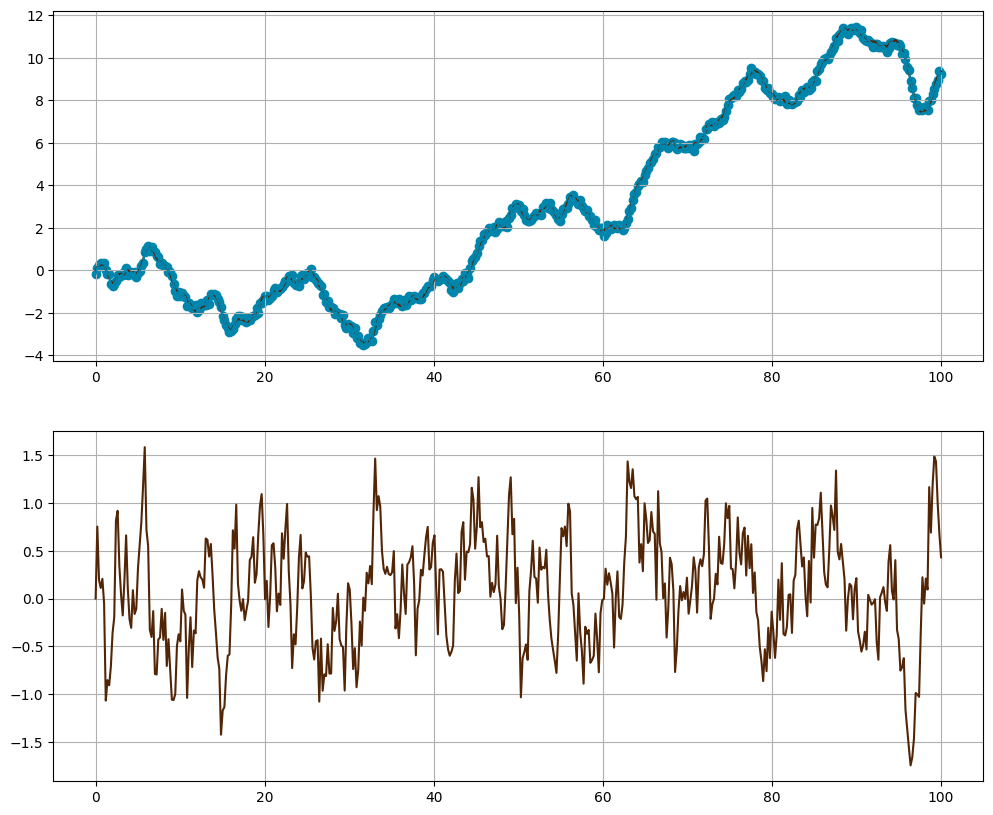

In [30]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

ax[0].plot(T, x[:,0,:], color="#522506")
ax[0].scatter(T, y[:,0,:], color="#0085ad")
ax[0].plot(T, y[:,0,:], color="#0085ad")
ax[0].grid(True)

ax[1].plot(T, x[:,1,:], color="#522506")
ax[1].grid(True)

plt.show()

In [4]:
def system_noise(s, t):
    dt = t - s
    return np.random.normal(loc=0., scale=np.sqrt(dt), size=(2,1))

def measurement_noise(t):
    return np.random.normal(loc=0., scale=np.sqrt(0.5), size=(1,1))

In [5]:
langevin_model = LangevinModel(subordinator=None, theta=-2., shape=(2,2))

H = np.zeros((1,2))
H[0][0] = 1

In [6]:
config = {"A":langevin_model.expA, "I":system_noise, "H":H, "eps":measurement_noise}

ssm = BaseStateSpaceModel(**config)

In [7]:
T = np.linspace(0, 100, num=500).reshape(-1, 1)

In [9]:
x, y = ssm.sample(times=T)

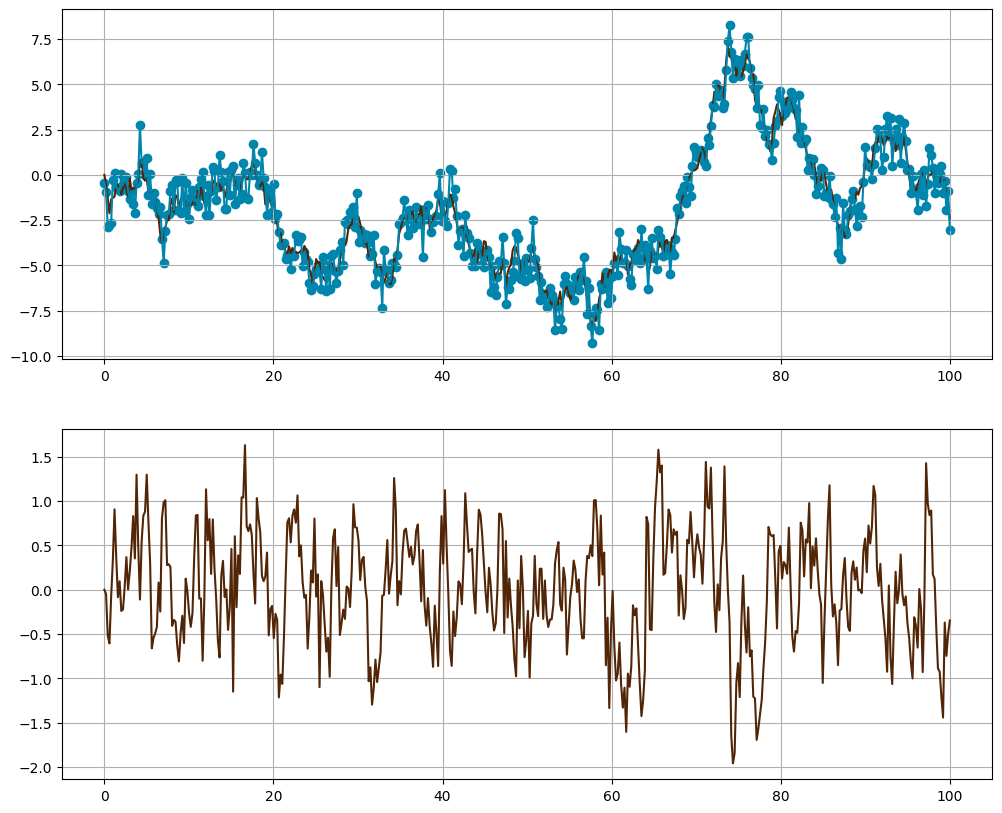

In [10]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

ax[0].plot(T, x[:,0,:], color="#522506")
ax[0].scatter(T, y[:,0,:], color="#0085ad")
ax[0].plot(T, y[:,0,:], color="#0085ad")
ax[0].grid(True)

ax[1].plot(T, x[:,1,:], color="#522506")
ax[1].grid(True)

plt.show()

In [2]:
class ConstantVelocityTransitionMatrix(LinearOperator):
    parameter_keys = ["shape"]

    def compute_drift_matrix(self, dt=None):
        return np.array([[0, 1],[0, 0]])

    def compute_matrix(self, dt):
        expA = np.zeros(self.shape)
        expA[0][0] = 1.
        expA[0][1] = dt
        expA[1][1] = 1.
        return expA
    
class LangevinTransitionMatrix(LinearOperator):
    parameter_keys = ["shape", "theta"]

    def compute_drift_matrix(self, dt=None):
        return np.array([[0, 1],[0, self.theta]])

    def compute_matrix(self, dt):
        expA = np.zeros(self.shape)
        expA[0][0] = 1.
        expA[0][1] = (np.exp(self.theta*dt) - 1) / self.theta
        expA[1][1] = np.exp(self.theta*dt)
        return expA
    
class SimpleFunction(LinearOperator):
    parameter_keys = ["shape", "indicator_dim", "value"]

    def compute_matrix(self, dt=None):
        h = np.zeros(self.shape)
        h[self.indicator_dim[0]][self.indicator_dim[1]] = self.value
        return h

In [3]:
class ForcingFunction(ParameterInterface):
    parameter_keys = None

    def get_parameter_values(self):
        parameters = super().get_parameter_values()
        # Remove the shape key as it will not be changed after initialisation.
        del parameters["shape"]
        return parameters

    def sample(self, s=None, t=None, func=None):
        pass

    def __call__(self, s=None, t=None, func=None):
        return self.sample(s=s, t=t, func=func)
    
class WienerProcess(ForcingFunction):
    parameter_keys = ["shape", "sigma"]

    def set_covariance_function(self, func):
        self.cov = func

    def sample(self, s=None, t=None, func=None):
        dW = np.random.multivariate_normal(mean=np.zeros(self.shape[0]), cov=self.sigma*self.cov(t-s), size=1).T
        return dW

In [4]:
class Noise(ParameterInterface):
    parameter_keys = None

    def sample(self, t=None):
        pass

    def __call__(self, t=None):
        return self.sample(t=t)
    
class GaussianNoise(Noise):
    parameter_keys = ["shape"]

    def sample(self, t=None):
        return np.random.randn(self.shape[0], self.shape[1])

In [5]:
class BaseStateSpaceModel:

    def __init__(self, system_noise, measurement_noise):
        # Set driving stochastic processes
        self.system_noise = system_noise
        self.measurement_noise = measurement_noise

        # Transition matrix
        self.A = None

        # System noise matrix
        self.h = None        

        # Measurement matrix
        self.H = None

        # Measurement noise matrix
        self.C = None

    def get_parameter_values(self):
        pass
    
    def set_parameter_values(self, **kwargs):
        pass

    def sample(self, times, size=1):
        # Initialise state and measurement arrays:
        ## The number of columns in x_init should be configurable.
        ## We assume that X starts with [0 ... 0]^T
        x_init = np.zeros((self.A.shape[1], 1))

        ## The third dimension of this array has to be same as the number of columns in x_init.
        x = np.zeros(shape=(times.shape[0], x_init.shape[0], 1))

        ## The number of columns in y should be configurable.
        y = np.zeros(shape=(times.shape[0], self.H.shape[0], 1))

        x[0] = x_init
        y[0] = self.H @ x[0] + self.C @ self.measurement_noise(t=times[0])

        for i in range(1, times.shape[0]):
            dt = times[i] - times[i-1]

            x[i] = self.A(dt) @ x[i-1] + self.system_noise(s=times[i-1], t=times[i], func=self.h)
            y[i] = self.H @ x[i-1] + self.C @ self.measurement_noise(t=times[i])

        return x, y

## Sampling points:

In [6]:
T = np.linspace(0, 100, num=500).reshape(-1, 1)

## Constant Velocity Model:

In [7]:
def constant_velocity_matrix(dt):
    dt = dt[0]

    return np.array([[dt**3/3, dt**2/2],[dt**2/2, dt]])

In [8]:
system_noise = WienerProcess(**{"shape":(2,1), "sigma":1.})
system_noise.set_covariance_function(func=constant_velocity_matrix)

measurement_noise = GaussianNoise(**{"shape":(1,1)})

model = BaseStateSpaceModel(system_noise, measurement_noise)

In [9]:
drift_parameters = {"shape":(2,2)}
system_matrix = ConstantVelocityTransitionMatrix(**drift_parameters)

system_noise_parameters = {"shape":(2,1), "indicator_dim":(1,0), "value":1.}
h = SimpleFunction(**system_noise_parameters)

system_noise_matrix = h

In [10]:
model.A = system_matrix
model.h = system_noise_matrix

In [11]:
H = np.zeros((1,2))
H[0][0] = 1

model.H = H

In [12]:
C = np.array([1])[np.newaxis]
model.C = C

In [13]:
x, y = model.sample(T)

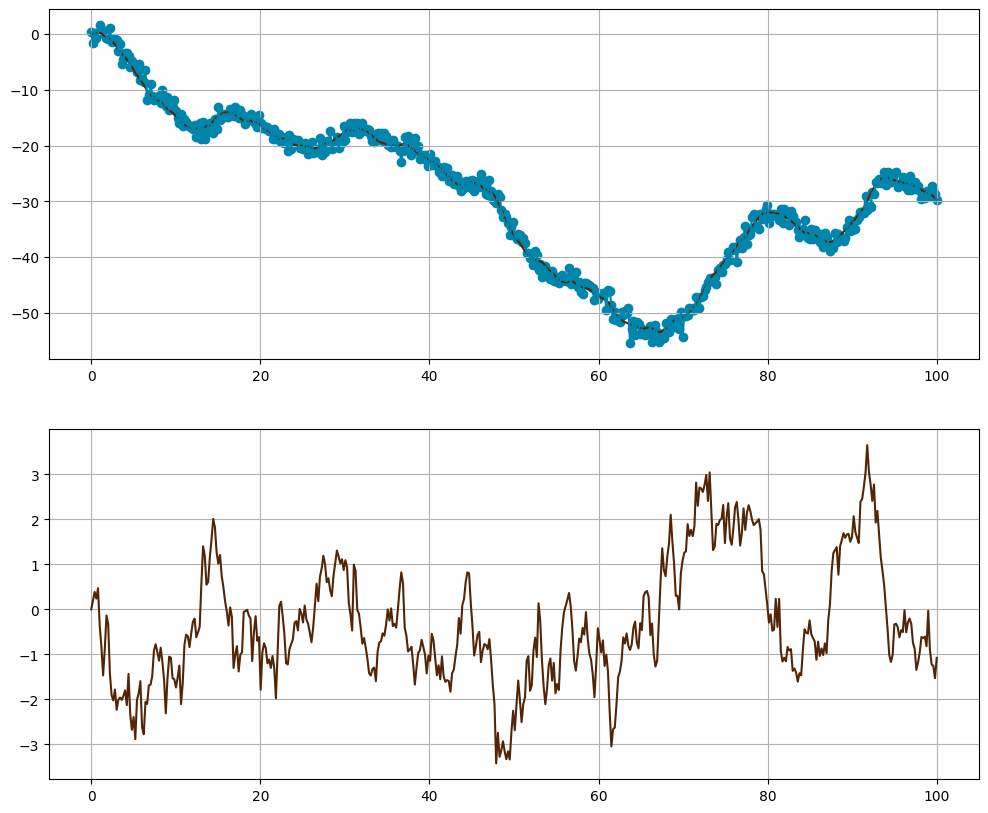

In [14]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

ax[0].plot(T, x[:,0,:], color="#522506")
ax[0].scatter(T, y[:,0,:], color="#0085ad")
ax[0].plot(T, y[:,0,:], color="#0085ad")
ax[0].grid(True)

ax[1].plot(T, x[:,1,:], color="#522506")
ax[1].grid(True)

plt.show()

## Langevin Model:

In [ ]:
system_noise = WienerProcess(**{"shape":(2,1), "sigma":1.})
system_noise.set_covariance_function(func=constant_velocity_matrix)

measurement_noise = GaussianNoise(**{"shape":(1,1)})

model = BaseStateSpaceModel(system_noise, measurement_noise)

In [ ]:
system_noise = BrownianMotion(**{"shape":(1,1)})
measurement_noise = GaussianNoise(**{"shape":(1,1)})

model = BaseStateSpaceModel(system_noise, measurement_noise)

In [3]:
class ForcingTerm(ParameterInterface):
    parameter_keys = None

    def sample(self, s=None, t=None, func=None):
        pass

    def __call__(self, s=None, t=None, func=None):
        return self.sample(s=s, t=t, func=func)
    
class BrownianMotion(ForcingTerm):
    parameter_keys = ["shape"]

    def sample(self, s=None, t=None, func=None):
        dW = np.random.randn(self.shape[0], self.shape[1])
        return func(t-s) @ dW
    
class Noise(ParameterInterface):
    parameter_keys = None

    def sample(self, t=None):
        pass

    def __call__(self, t=None):
        return self.sample(t=t)
    
class GaussianNoise(Noise):
    parameter_keys = ["shape"]

    def sample(self, t=None):
        return np.random.randn(self.shape[0], self.shape[1])

In [41]:
class BaseStateSpaceModel:

    def __init__(self, system_noise, measurement_noise):
        # Set driving stochastic processes
        self.system_noise = system_noise
        self.measurement_noise = measurement_noise

        # Transition matrix
        self.A = None

        # System noise matrix
        self.h = None        

        # Measurement matrix
        self.H = None

        # Measurement noise matrix
        self.C = None

    def get_parameter_values(self):
        pass
    
    def set_parameter_values(self, **kwargs):
        pass

    def sample(self, times, size=1):
        # Initialise state and measurement arrays:
        ## The number of columns in x_init should be configurable.
        ## We assume that X starts with [0 ... 0]^T
        x_init = np.zeros((self.A.shape[1], 1))

        ## The third dimension of this array has to be same as the number of columns in x_init.
        x = np.zeros(shape=(times.shape[0], x_init.shape[0], 1))

        ## The number of columns in y should be configurable.
        y = np.zeros(shape=(times.shape[0], self.H.shape[0], 1))

        x[0] = x_init
        y[0] = self.H @ x[0] + self.C @ self.measurement_noise(t=times[0])

        for i in range(1, times.shape[0]):
            dt = times[i] - times[i-1]

            x[i] = self.A(dt) @ x[i-1] + self.system_noise(s=times[i-1], t=times[i], func=self.h)
            y[i] = self.H @ x[i-1] + self.C @ self.measurement_noise(t=times[i])

        return x, y

## Sampling points:

In [5]:
T = np.linspace(0, 100, num=500).reshape(-1, 1)

## Constant Velocity Model:

In [6]:
system_noise = BrownianMotion(**{"shape":(1,1)})
measurement_noise = GaussianNoise(**{"shape":(1,1)})

model = BaseStateSpaceModel(system_noise, measurement_noise)

In [7]:
drift_parameters = {"shape":(2,2)}
system_matrix = ConstantVelocityTransitionMatrix(**drift_parameters)

system_noise_parameters = {"shape":(2,1), "indicator_dim":(1,0), "value":1.}
h = SimpleFunction(**system_noise_parameters)

system_noise_matrix = h

In [8]:
model.A = system_matrix
model.h = system_noise_matrix

In [9]:
H = np.zeros((1,2))
H[0][0] = 1

model.H = H

In [10]:
C = np.array([1])[np.newaxis]
model.C = C

In [12]:
x, y = model.sample(T)

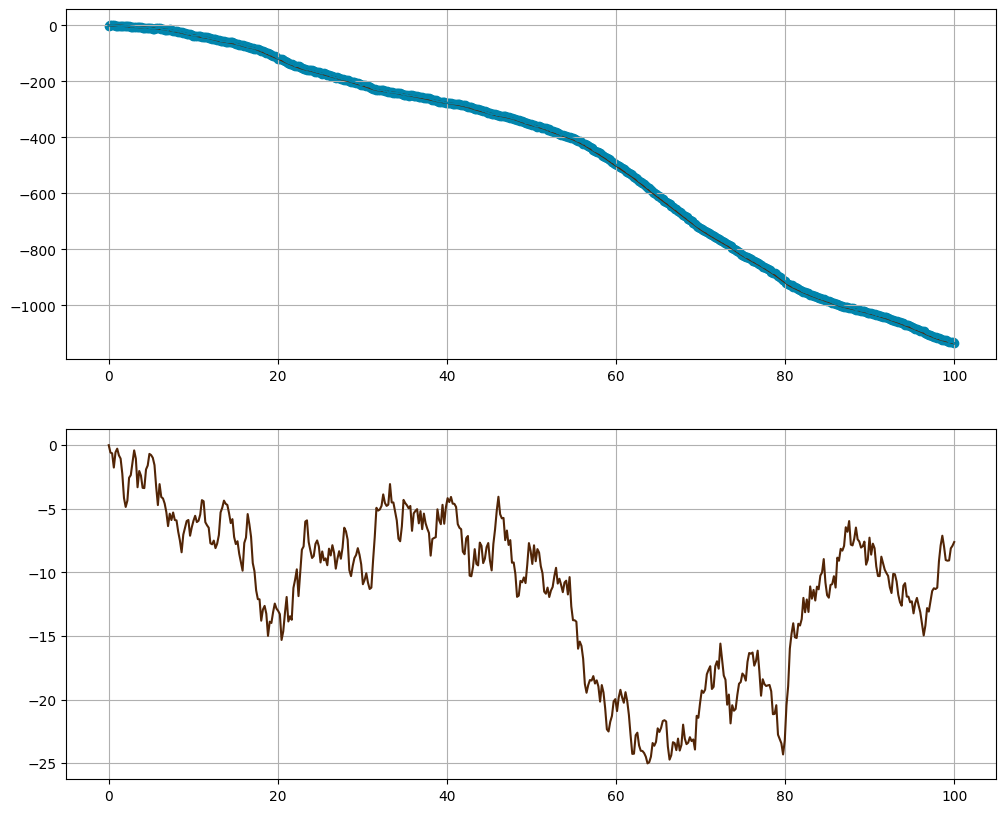

In [13]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

ax[0].plot(T, x[:,0,:], color="#522506")
ax[0].scatter(T, y[:,0,:], color="#0085ad")
ax[0].plot(T, y[:,0,:], color="#0085ad")
ax[0].grid(True)

ax[1].plot(T, x[:,1,:], color="#522506")
ax[1].grid(True)

plt.show()

##   Langevin Model:

In [14]:
system_noise = BrownianMotion(**{"shape":(1,1)})
measurement_noise = GaussianNoise(**{"shape":(1,1)})

model = BaseStateSpaceModel(system_noise, measurement_noise)

In [15]:
drift_parameters = {"shape":(2,2), "theta":-2.}
system_matrix = LangevinTransitionMatrix(**drift_parameters)

system_noise_parameters = {"shape":(2,1), "indicator_dim":(1,0), "value":1.}
h = SimpleFunction(**system_noise_parameters)

system_noise_matrix = lambda u: system_matrix(u) @ h(u)

In [16]:
model.A = system_matrix
model.h = system_noise_matrix

In [17]:
H = np.zeros((1,2))
H[0][0] = 1

model.H = H

In [18]:
C = np.array([1])[np.newaxis]
model.C = C

In [19]:
model.A.get_parameter_values()

{'theta': -2.0}

In [19]:
x, y = model.sample(T)

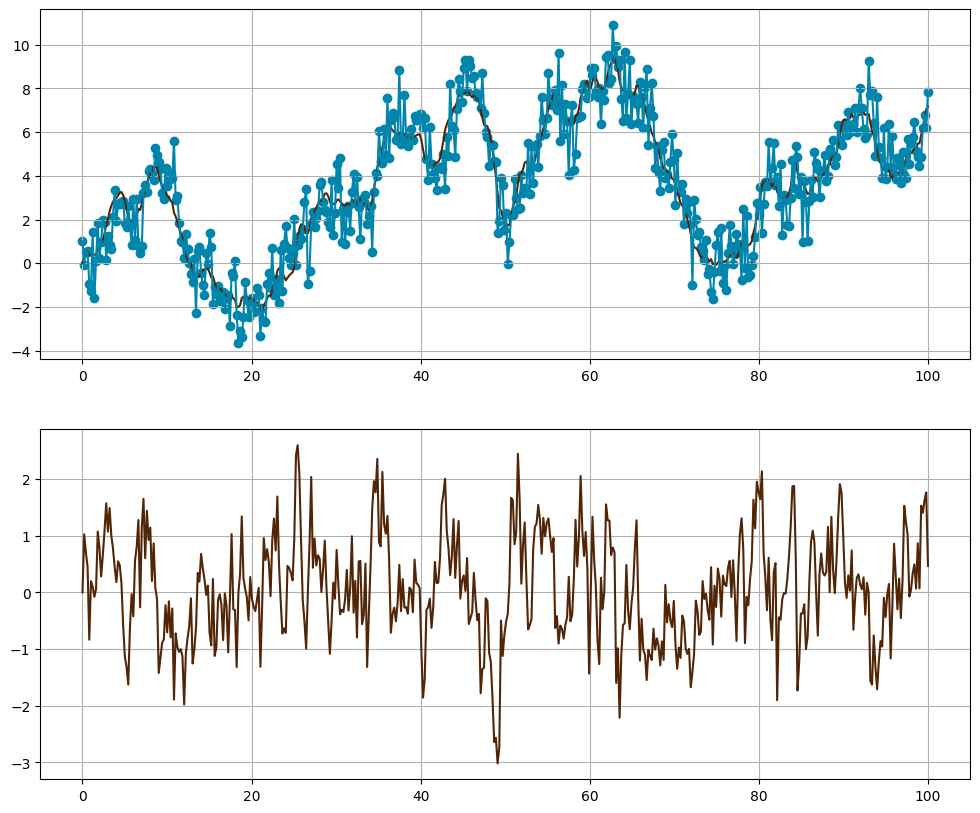

In [20]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

ax[0].plot(T, x[:,0,:], color="#522506")
ax[0].scatter(T, y[:,0,:], color="#0085ad")
ax[0].plot(T, y[:,0,:], color="#0085ad")
ax[0].grid(True)

ax[1].plot(T, x[:,1,:], color="#522506")
ax[1].grid(True)

plt.show()

In [11]:
# Kalman filter:

x_init = np.random.normal(loc=0., scale=1., size=(D, 1))

P_init = np.random.normal(loc=0., scale=1., size=(D, D))
P_init = np.matmul(P_init.T, P_init)

# Initialise estimate
x_est = np.zeros(shape=(N+1, x_init.shape[0], 1))
x_pred = np.zeros(shape=(N, x_init.shape[0], 1))

P_est = np.zeros(shape=(N+1, P_init.shape[0], P_init.shape[1]))
P_pred = np.zeros(shape=(N, P_init.shape[0], P_init.shape[1]))

x_est[0] = x_init
P_est[0] = P_init


In [12]:
for i in range(1, y.shape[0]+1):
    # Predict:
    x_pred[i-1] = A @ x_est[i-1]
    P_pred[i-1] = A @ P_est[i-1] @ A.T + Q

    # Update:
    residual_pred = y[i-1] - H @ x_pred[i-1]
    residual_pred_cov = H @ P_pred[i-1] @ H.T + R
    kalman_gain = P_pred[i-1] @ H.T @ invert_covariance(residual_pred_cov)

    x_est[i] = x_pred[i-1] + kalman_gain @ residual_pred
    P_est[i] = (np.eye(D) - kalman_gain @ H) @ P_pred[i-1]

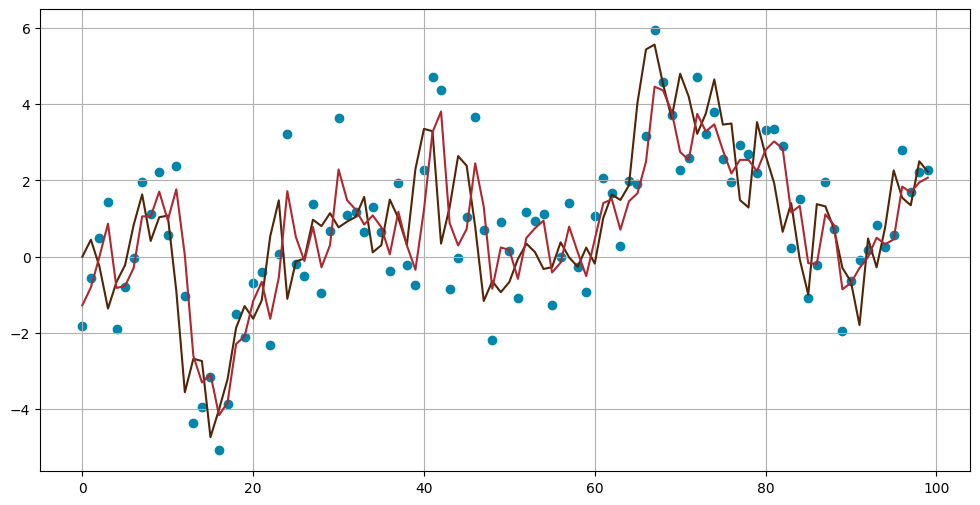

In [13]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(t, x[:,0,:], color="#522506")
ax.scatter(t, y[:,0,:], color="#0085ad")
#ax.plot(t, y[:,0,:], color="#0085ad")

ax.plot(t, x_est[1:,0,:], color="#AF272F")
ax.grid(True)

plt.show()